In [1]:
# IMPORT PACKAGES

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import rcParams  # next 3 lines set font family for plotting
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['TImes New Roman']
import matplotlib.pyplot as plt
import os
import time

C:\Users\Kathy_Breen\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# SETTINGS FOR REPRODUCIBLE RESULTS DURING DEVELOPMENT

#import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

#import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


X dimensions: (100000, 1)
Y dimensions: (100000, 1)


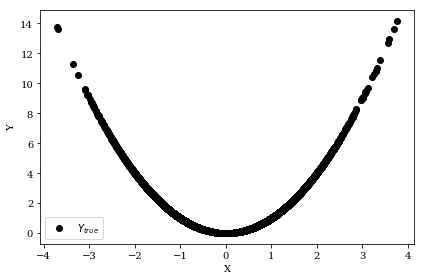

In [3]:
# Create some simple data for a known function (y = x^2)

# generate 100,000 samples (x dimension) with 1 features each (y dimension)
X = np.random.randn(100000,1)
Y = np.square(X)
X_Nfeatures = X.shape[1]
Y_Nfeatures = Y.shape[1]

# partition X and Y into training (90%) and test (10%) sets
X_train = X[:90000,:]
X_test = X[90000:,:]
Y_train = Y[:90000,:]
Y_test = Y[90000:,:]

print('X dimensions:',X.shape)
print('Y dimensions:',Y.shape)

fig = plt.figure(num=1)
ax = fig.add_subplot(111)
y_true = ax.plot(X_test,Y_test,'ko',label=r'$Y_{true}$')
ax.set_xlabel('X')
ax.set_ylabel('Y')
curves = y_true
labels = [c.get_label() for c in curves]
ax.legend(curves, labels, loc=0)
plt.tight_layout()
plt.savefig('ytrue.pdf')
plt.show()

In [4]:
# Build the DLM

tic = time.time()  # start a timer

# HYPERPARAMETERS
epochs = 5000
batch_size = 5000
do = 0.2
N_nodes = 64

# create input layer..........
main_input = Input(shape=(X_Nfeatures),
                   dtype='float',
                   batch_shape=(batch_size,X_Nfeatures),
                   name='main_input'
                   )
#create hidden layer..........
hidden_layer1 = Dense(N_nodes, activation='relu', name='hidden_layer1')(main_input)
# add dropout to hidden layer
Dropout(do)(hidden_layer1)

hidden_layer2 = Dense(N_nodes, activation='relu', name='hidden_layer2')(hidden_layer1)
# add dropout to hidden layer
Dropout(do)(hidden_layer2)

# create output layer
main_output = Dense(Y_Nfeatures, name='main_output')(hidden_layer2)  # default activation is linear

# feed datasets into model for training
model = Model(inputs=[main_input], 
              outputs=[main_output]
              )

# compile the model with desired configuration
model.compile(loss='mean_squared_error',
              optimizer='adagrad',
              metrics=['mae'])

# one of several callbacks available in Keras, csv_logger saves metrics for every epoch to a csv file
csv_logger = CSVLogger('training_' + str(epochs) + '.log')

early_stop = EarlyStopping(monitor='val_loss', # quantity to monitor
                           min_delta=0.0001,  # min change to qualify as an improvement
                           patience=10, # stop after #epochs with no improvement
                           verbose=1)  # print messages

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,  # reduction factor (new_lr = lr * factor)
                              patience=5,
                              verbose=1)

# train the model, and store training information in the history object
history = model.fit([X_train],[Y_train],
                    epochs=epochs,
                    batch_size = batch_size,
                    validation_data=(X_test, Y_test),
                    callbacks=[reduce_lr,early_stop,csv_logger]
                    )
model.summary()  # print out a summary of layers/parameters
config = model.get_config()  # detailed information about the configuration of each layer

# evaluate the trained model on the test data set
test = model.evaluate([X_test],[Y_test],batch_size=batch_size)  
names = model.metrics_names

X_pred = np.random.randn(100000,1)
Y_pred = np.square(X_pred)
predict = model.predict([X_pred],batch_size=batch_size)
Y_mse = mean_squared_error(predict,Y_pred)
print('Y_mse:',Y_mse)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 90000 samples, validate on 10000 samples
Epoch 1/5000
90000/90000 [==============================] - 0s 5us/step - loss: 1.1451 - mean_absolute_error: 0.6084 - val_loss: 0.5433 - val_mean_absolute_error: 0.4995
Epoch 2/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.4322 - mean_absolute_error: 0.4248 - val_loss: 0.3065 - val_mean_absolute_error: 0.3361
Epoch 3/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.2532 - mean_absolute_error: 0.2920 - val_loss: 0.1899 - val_mean_absolute_error: 0.2445
Epoch 4/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.1642 - mean_absolute_error: 0.2201 - val_loss: 0.1301 - val_mean_absolute_error: 0.1911
Epoch 5/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.1159 - mean_absolute_error: 0.1689 - val_loss: 0.0947 - val_mean_absolute_error: 0.1485
Epoch 6/5000
90000/90000 [=

Epoch 47/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0037 - mean_absolute_error: 0.0123 - val_loss: 0.0027 - val_mean_absolute_error: 0.0113
Epoch 48/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0036 - mean_absolute_error: 0.0118 - val_loss: 0.0026 - val_mean_absolute_error: 0.0117
Epoch 49/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0035 - mean_absolute_error: 0.0120 - val_loss: 0.0025 - val_mean_absolute_error: 0.0113
Epoch 50/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0034 - mean_absolute_error: 0.0114 - val_loss: 0.0025 - val_mean_absolute_error: 0.0127
Epoch 51/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0033 - mean_absolute_error: 0.0119 - val_loss: 0.0024 - val_mean_absolute_error: 0.0123
Epoch 52/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0032 - mean_absolute_error: 0.0116 - val_loss: 0.0023 - val_me

Epoch 95/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0015 - mean_absolute_error: 0.0077 - val_loss: 9.2694e-04 - val_mean_absolute_error: 0.0074
Epoch 96/5000
70000/90000 [======================>.......] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0066    
Epoch 00096: reducing learning rate to 0.0019999999552965165.
90000/90000 [==============================] - 0s 1us/step - loss: 0.0015 - mean_absolute_error: 0.0065 - val_loss: 9.1604e-04 - val_mean_absolute_error: 0.0065
Epoch 97/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0014 - mean_absolute_error: 0.0060 - val_loss: 9.0075e-04 - val_mean_absolute_error: 0.0058
Epoch 98/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0014 - mean_absolute_error: 0.0059 - val_loss: 8.9714e-04 - val_mean_absolute_error: 0.0058
Epoch 99/5000
90000/90000 [==============================] - 0s 1us/step - loss: 0.0014 - mean_absolute_error: 0.0059 - val_loss: 9.01

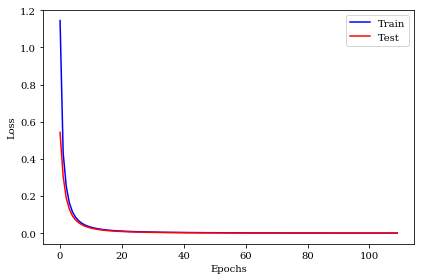

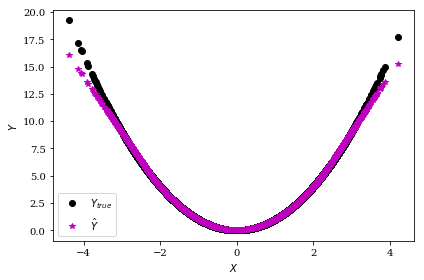

In [5]:
loss_train = history.history['loss']
loss_test = history.history['val_loss']
xplot = list(range(len(loss_train)))

fig = plt.figure(num=2)
ax = fig.add_subplot(111)
train = ax.plot(xplot,loss_train,'b-',label='Train')
test = ax.plot(xplot,loss_test,'r-',label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
curves = train+test
labels = [c.get_label() for c in curves]
ax.legend(curves, labels, loc=0)
plt.tight_layout()
plt.savefig('loss' + str(epochs) + 'epochs.pdf')
plt.show()

fig = plt.figure(num=3)
ax = fig.add_subplot(111)
y_true = ax.plot(X_pred,Y_pred,'ko',label=r'$Y_{true}$')
y_pred = ax.plot(X_pred,predict,'m*',label=r'$\hat{Y}$')
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
curves = y_true+y_pred
labels = [c.get_label() for c in curves]
ax.legend(curves, labels, loc=0)
plt.tight_layout()
plt.savefig('ypred.pdf')
plt.show()
